# Questions/Concerns

Confirm weight of new rocket and that OpenRocket LV3_L13a_ideal.ork is the correct OpenRocket file to reference

WATCH OUT FOR UNIT CONVERSIONS!!! Parachute parameters are given in ENGLISH, but the majority of this document will be in METRIC

Nate's note: You know the altitude and time (in seconds) at the top of the flight, and you know the altitude (preset to 300 meters, I think) and time the main chute opened (you can see the main open as a spike in the accelerometer data). The rocket spends very close to 100% of it's time at terminal velocity during this time, so the terminal velocity is also the average velocity. You could get a very good estimate by dividing distance and time (for terminal velocity on the drogue):

(apogee - main_chute_alt) / (main_open_t - apogee_t)
You can do something similar for the main.

Another way might be to look at barometer data, if you can find it. Barometer-based velocity data should be very accurate on the way down! It's pretty bad for ascent because of Mach effects, but on the parachutes it's very useful.

*Need to figure out how to calculate necessary drogue size...only have equation for main right now

Did we use a shock cord for LV2?

# LV2 recovery system information

## Drogue 'chute

*Hand measured

Diameter (length of cross) = 54"

Width = 17"

Longest line length = 56"

## Main 'chute

Dimensions, total outer: 216.54" x 218.54" (reference Main.dxf)

Dimensions, inner cross: 64.01"

Corner line length, skirt to confluence: 205"

Center lines lengthen 3%

*Hand measured

Diameter = 212"

Width = 55"

Longest line length = 198"

# Initial calculations

## Current information and requirements

Assumptions$^{[1]}$:
    1. Linear motion
    2. The deployment system is inelastic
    3. The partially unfurled parachute is in tension during deployment
    4. The deployment rate is much less than the vehicle velocity
    
The parachute depends on two main factors$^{[2]}$:
    1. The weight of the payload and parachute
    2. The speed upon impact when returning
    
Canopy first deployment


In [42]:
#General
########################################

#gravity (m/sec^2)
g = 9.81

#air density (kg/m^3)
p = 1.225

#LV2 information
#######################################

print ("LV2 Information\n")

#mass of parachute (kg)
#From OpenRocket
m_p2 = 2.118

#mass of system (rocket + chute) (kg)
#From OpenRocket LV2.3.ork
m_tot2 = 34.982

#weight of system (N)
w_tot2 = m_tot2 * g
print ("w_tot2 (N) %3.2f" % w_tot2)

#main parachute dimensions
#diameter, d2 = length of one cross strip (m)
#width of cross strip, w2 (m)
#almost the same w/d ratio as AIAA source [4] (0.263 compared to 0.260)
#line length, l2 (m)
d2 = 5.38
w2 = 1.40
l2 = 5.03

#area of parachute from LV2 system
A2 = ((d2*w2)*2)-(w2**2)
print ("A2 (m^2) %3.2f" % A2)

LV2 Information

w_tot2 (N) 343.17
A2 (m^2) 13.10


[-4532339832 -4530896143 -4529866822 ..., 45563275819 45564335032
 45565723617]
[ -4.53233983  -4.53089614  -4.52986682 ...,  45.56327582  45.56433503
  45.56572362]


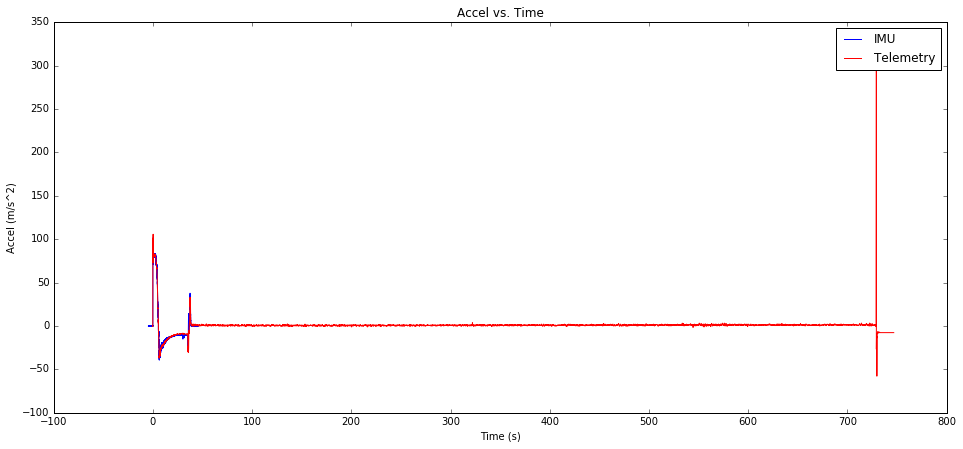

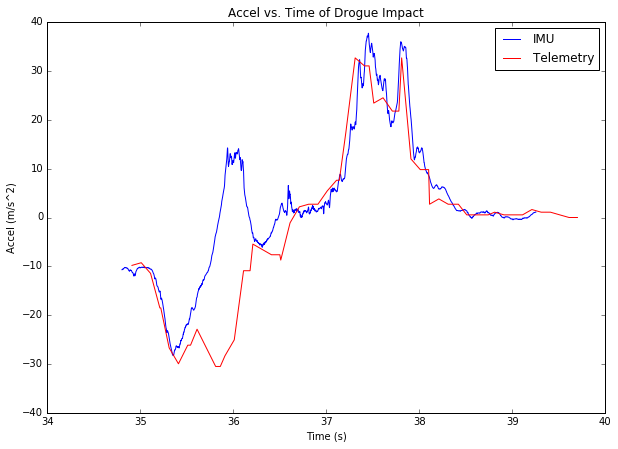

In [43]:
#Analyzing LV2 telemetry and IMU data
##From git, Launch 12
#######################################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import simps
%matplotlib inline

# Graphing helper function
def setup_graph(title='',x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0],
                            fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

########################################

#This data is from the IMU and is the "raw" data
##i.e. NOT from the TeleMetrum
data = pd.read_csv('IMU_data.csv')
#print data.keys()

time = data[' [1]Timestamp'].tolist()

time = np.array(time)

# umblicial disconnect event
t_0 = 117853569585227

# element wise subtraction
time = np.subtract(time, t_0)
print (time)
# convert from ns to s
time = np.divide(time, 1e9)
print (time)

acceleration = data[' [6]Acc_X'].tolist()
acceleration = np.array(acceleration)
acceleration = np.subtract(acceleration,g)

########################################
#This data is from the Telemetry data
data_tel = pd.read_csv('Telemetry_data.csv')
#print data2.keys()

time_tel = data_tel['time'].tolist()
time_tel = np.array(time_tel)
acceleration_tel = data_tel['acceleration'].tolist()
acceleration_tel = np.array(acceleration_tel)

setup_graph('Accel vs. Time', 'Time (s)', 'Accel (m/s^2)', (16,7))
plt.plot(time,acceleration,'b-')
plt.plot(time_tel, acceleration_tel,'r-')
plt.legend(['IMU','Telemetry'])
plt.show()

#drogue analysis
#plot of only the duration of impulse

setup_graph('Accel vs. Time of Drogue Impact', 'Time (s)', 'Accel (m/s^2)', (10,7))
plt.plot(time[len(time)-8700:35500], acceleration[len(acceleration)-8700:35500],'b-')
plt.plot(time_tel[len(time_tel)-9808:3377], acceleration_tel[len(acceleration_tel)-9808:3377],'r-')
plt.legend(['IMU','Telemetry'])
plt.show()

## suggestions

Your $dt$ value is a bit off. Also, $dt$ changes, especially when the drogue is deploying.

The other thing that I'd be careful about is your assumption that the deployment force is just the $\Delta v$ for deployment divided by the time. That would mean the force is as spread out as possible, which isn't true. 

Also, I think it's a reasonable guess that the IMU was zeroed on the launch pad. This means that 
1. The acceleration data isn't *quite* representative of the load on the parachute/rocket.
1. We can get a calibration factor for the IMU data.

At apogee, right before the drogue deploys, the rocket is basically in freefall. Aka, any accelerometer "should" read $0$. So, whatever the IMU reads at apogee is equal to $1 g$. We can then subtract out that value and scale the data so that we get $9.81$ on the launch pad. 

mean dt value: 0.00123369935601
change in velocity (area under the curve): 51.9145873752
"pretty much zeroed" value on the launch pad: 0.008200468503


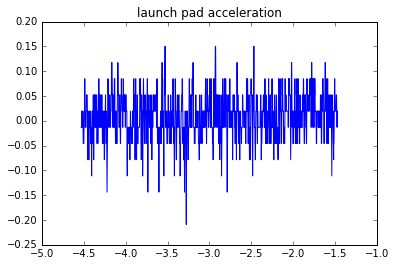

In [44]:
# how to get the values for dt:
#diffs= [t2-t1 for t1,t2 in zip(time[:-1], time[1:])]
#plt.figure()
#plt.plot(time[1:], diffs)
#plt.title('values of dt')
print('mean dt value:', np.mean(diffs))

# marginally nicer way to keep track of time windows:
ind_drogue= [i for i in range(len(time)) if ((time[i]>34.5) & (time[i]<39))]

# indices where we're basically in freefall:
ind_vomit= [i for i in range(len(time)) if ((time[i]>32) & (time[i]<34.5))]
offset_g= np.mean(acceleration[ind_vomit])
accel_nice = (acceleration-offset_g)*(-9.81/offset_g)
deltaV= sum([accel_nice[i]*diffs[i] for i in ind_drogue])
print('change in velocity (area under the curve):', deltaV)

plt.figure()
plt.plot(time[:2500], acceleration[:2500])
plt.title('launch pad acceleration')
print('"pretty much zeroed" value on the launch pad:', np.mean(acceleration[:2500]))

849.31983802
Area under drogue accel curve 45.80
impulse 1602.11


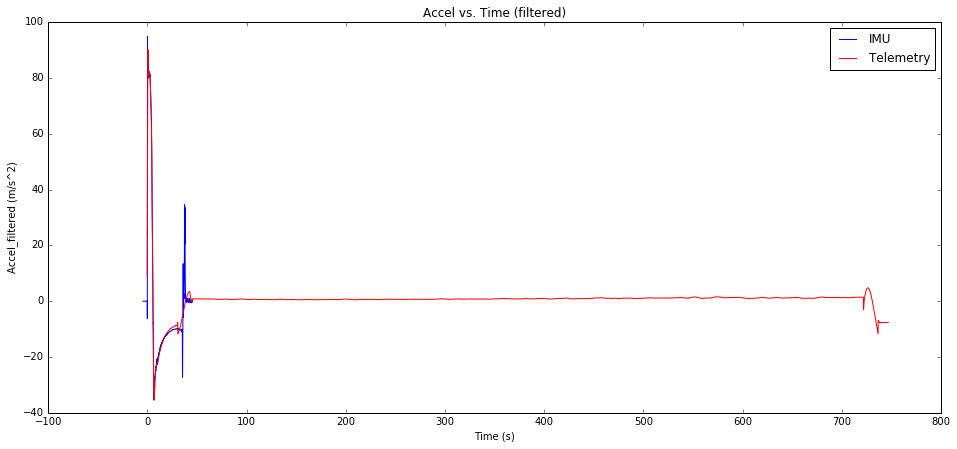

In [45]:
###Filter out noise w/ scipy

##From IMU
from scipy.signal import savgol_filter
accel_filtered = savgol_filter(acceleration, 201, 2)

# Estimate Area Under Curve
areaCurve = simps(abs(accel_filtered), dx=0.00125)
print (areaCurve)

#calculating area under drogue acceleration curve to find impulse
areaCurvesmall = simps(abs(accel_filtered[len(accel_filtered)-8700:35500]), dx=0.00125)
print ("Area under drogue accel curve %3.2f" %areaCurvesmall)
#impulse = mass * integral(accel dt)
impulse = m_tot2 * areaCurvesmall
print ("impulse %3.2f" %impulse)
#if deploy time = approx. 3.5 sec
deploy_time = 3.5
force = impulse/deploy_time # not a conservative assumption

##From telemetry
##***Assuming the filter parameters will work for the telemetry data too***
accel_filtered_tel = savgol_filter(acceleration_tel, 201, 2)

#plot of filtered IMU and telemetry for comparison
setup_graph('Accel vs. Time (filtered)', 'Time (s)', 'Accel_filtered (m/s^2)', (16,7))
plt.plot(time[1:], accel_filtered[1:],'b-')
plt.plot(time_tel[1:], accel_filtered_tel[1:],'r-')
plt.legend(['IMU','Telemetry'])
plt.show()
#looks pretty darn close
#Wanted the filtered telemetry instead of IMU because IMU does not include landing and we need terminal velocity

In [46]:
"""
#Therefore, integrating the filtered telemetry should provide a good estimate for the terminal (impact) velocity
velocity_tel = []
for j in range(len(accel_filtered)):
    if(j > 0):
        # use simpsons rule on the samples to integrate
        velocity_tel.append(simps(accel_filtered[:j], time[:j]))
velocity_tel = np.array(velocity_tel)
print velocity_tel

velocity_tel = []
for j in range(len(accel_filtered_tel)):
    if(j > 0):
        # use simpsons rule on the samples to integrate
        velocity_tel.append(simps(accel_filtered_tel[:j], time_tel[:j]))
velocity_tel = np.array(velocity_tel)
print velocity_tel


#plotting IMU w/ telemetry just as a check
velocity_IMU = []
for i in range(len(accel_filtered)):
    if(i > 0):
        # use simpsons rule on the samples to integrate
        velocity_IMU.append(simps(accel_filtered[:i], time[:i]))
velocity_IMU = np.array(velocity_IMU)

#plt.plot(time[1:], velocity_IMU,'b-')
plt.plot(time, velocity_IMU,'r-')
#plt.legend(['IMU','Telemetry'])
plt.show()
"""

"\n#Therefore, integrating the filtered telemetry should provide a good estimate for the terminal (impact) velocity\nvelocity_tel = []\nfor j in range(len(accel_filtered)):\n    if(j > 0):\n        # use simpsons rule on the samples to integrate\n        velocity_tel.append(simps(accel_filtered[:j], time[:j]))\nvelocity_tel = np.array(velocity_tel)\nprint velocity_tel\n\nvelocity_tel = []\nfor j in range(len(accel_filtered_tel)):\n    if(j > 0):\n        # use simpsons rule on the samples to integrate\n        velocity_tel.append(simps(accel_filtered_tel[:j], time_tel[:j]))\nvelocity_tel = np.array(velocity_tel)\nprint velocity_tel\n\n\n#plotting IMU w/ telemetry just as a check\nvelocity_IMU = []\nfor i in range(len(accel_filtered)):\n    if(i > 0):\n        # use simpsons rule on the samples to integrate\n        velocity_IMU.append(simps(accel_filtered[:i], time[:i]))\nvelocity_IMU = np.array(velocity_IMU)\n\n#plt.plot(time[1:], velocity_IMU,'b-')\nplt.plot(time, velocity_IMU,'r-')\

In [47]:
#Finding terminal velocity with barometer data
#Baro data does not seem accurate...
"""
velocity_baro = data_tel['baro_speed'].tolist()
velocity_baro = np.array(velocity_baro)

setup_graph('Velocity vs. Time', 'Time (s)', 'Velocity (m/s)', (16,7))
plt.plot(time_tel,velocity_baro,'g-')
plt.show()

setup_graph('Velocity vs. Time for terminal velocity', 'Time (s)', 'Velocity (m/s)', (16,5))
plt.plot(time_tel[len(time_tel)-13122:200],velocity_baro[len(velocity_baro)-13122:200],'g-')
plt.show()


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-47-edc0620b6d08>, line 13)

In [49]:
#Finding terminal velocity with height and time
#Assuming average velocity is equivalent to terminal velocity 
##because so much of the time after the main is deployed is at terminal velocity

#Using telemetry data
#main 'chute deployment height (m)
main_deploy_height = 251.6
#main 'chute deployment time (s)
main_deploy_time = 686.74
#final height (m)
final_height = 0
#final time
final_time = 728.51
#average (terminal) velocity (m/s)
terminal_speed = abs((main_deploy_height - final_height)/(main_deploy_time - final_time))
print ("terminal speed %3.2f" % terminal_speed)
#this seems accurate, 6 m/s is approx. 20 ft/s which is ideal

terminal speed 6.02


In [50]:
#LV2 drag calculations
#######################################

#If we say at terminal velocity, accel = 0, 
#therefore drag force (D2) = weight of system (w_tot2) (N)
#because sum(forces) = ma = 0, then
D2 = w_tot2
print ("D2 (N) %3.2f" % D2)

#calculated drag coefficient (Cd2), using D2
Cd2 = (2*D2)/(p*A2*(terminal_speed**2))
print ("Cd2 %3.2f" % Cd2)

#drag coefficient (Cd_or), from OpenRocket LV2.3
#compare to AIAA source [4], 0.60
#compare to calculated from LV2 data, Cd2
Cd_or = 0.59
print ("Cd_or %3.2f" % Cd_or)

#calculated drag (D_or) (N), from OpenRocket LV2.3
D_or = (Cd_or*p*A2*(terminal_speed**2))/2
print ("D_or (N) %3.2f" % D_or)

D2 (N) 343.17
Cd2 1.18
Cd_or 0.59
D_or (N) 171.81


## Parachute calculations
From source [2]

In [51]:
#Calculating area needed for LV3 parachutes
#both drogue and main

#from OpenRocket file LV3_L13a_ideal.ork
#total mass (kg)
#CONFIRM____Does not seem to include all components
m_tot3 = 27.667
#total weight (N)
w_tot3 = m_tot3 * g
#assuming drag is equivalent to weight of rocket system
D3 = w_tot3

#v_f3 (m/s), ideal terminal(impact) velocity
v_f3 = 6

#Cd from AIAA example (source 4)
Cd_aiaa = 0.60

#Cd from OpenRocket LV3
Cd_or3 = 0.38

#Printing previous parachute area for reference
print ("Previous parachute area %3.2f" %A2)
#Area needed using LV2 calculations (m^2)
A3_2 = (D3*2)/(Cd2*p*(v_f3**2))
print ("Area using Cd2 %3.2f" %A3_2)

#Area needed using LV2 OpenRocket (m^2)
A3_or2 = (D3*2)/(Cd_or*p*(v_f3**2))
print ("Area using Cd_or %3.2f" %A3_or2)

#Area needed using aiaa info (m^2)
A3_aiaa = (D3*2)/(Cd_aiaa*p*(v_f3**2))
print ("Area using Cd_aiaa %3.2f" %A3_aiaa)

#Area needed using LV3 OpenRocket
A3_or3 = (D3*2)/(Cd_or3*p*(v_f3**2))
print ("Area using Cd_or3 %3.2f" %A3_or3)

#Area estimater
A3 = (D3*2)/(1.5*p*(v_f3**2))
print ("Area estimate %3.2f" %A3)

Previous parachute area 13.10
Area using Cd2 10.45
Area using Cd_or 20.86
Area using Cd_aiaa 20.51
Area using Cd_or3 32.39
Area estimate 8.21


Sources for buying parachutes:

http://www.the-rocketman.com/chutes.html#standard

# Works Cited

[1] NASA TN D-5619

[2] http://www.pcprg.com/rocketre.htm

[3] http://www.dtic.mil/dtic/tr/fulltext/u2/731023.pdf

[4] AIAA-99-1711